In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np

from keras.layers import Dropout
from glob import glob
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = [224, 224]

train_path = 'datasets/Train'
valid_path = 'datasets/Test'



res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


# don't train existing weights
for layer in res.layers:
    layer.trainable = False
    
folders = glob('datasets/train/*')

x = Flatten()(res.output)
x= Dropout(0.5)(x)


prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

Directory  save_keras_model  already exists
Found 1042 images belonging to 4 classes.
Found 49 images belonging to 4 classes.
Index of each class: {'Geographic_tongue(glossitis)': 0, 'Healthy tongue': 1, 'balck hairy tongue': 2, 'fissured tongue': 3}
Total Samples of training images are: 1042
Total Samples of testing imagesare: 49
Epoch 1/5
104/104 [==============================] - 88s 849ms/step - loss: 3.8628 - accuracy: 0.3159 - val_loss: 3.1314 - val_accuracy: 0.2041
Epoch 2/5
104/104 [==============================] - 90s 864ms/step - loss: 3.0991 - accuracy: 0.3353 - val_loss: 1.7239 - val_accuracy: 0.2449
Epoch 3/5
104/104 [==============================] - 89s 857ms/step - loss: 2.6369 - accuracy: 0.3634 - val_loss: 6.2734 - val_accuracy: 0.2653
Epoch 4/5
104/104 [==============================] - 84s 809ms/step - loss: 2.9835 - accuracy: 0.3857 - val_loss: 2.9113 - val_accuracy: 0.2857
Epoch 5/5
104/104 [==============================] - 85s 814ms/step - loss: 3.0595 - accura

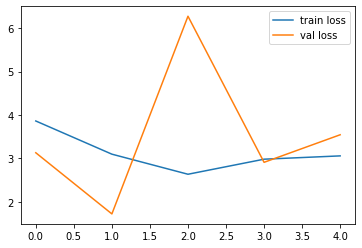

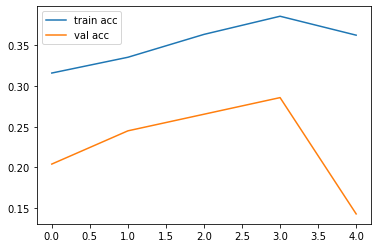

In [6]:
import os
import keras
# importing the checkpoint
from keras.callbacks import ModelCheckpoint


# Decide cost and optimization method 
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

current_cwd = os.getcwd()

# directory name where model will be saved
dirName = 'save_keras_model'

try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    
# creating the checkpoint directory. This is same where we need to save the model
checkpoint = dirName
# join the filename to the checkpoint directory
file_path = os.path.join(checkpoint,
                    "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")

# model saving provided only best model in the desired epochs are saved.
checkpoint = ModelCheckpoint(file_path, monitor='val_acc',
                             verbose=1, save_best_only=True, mode='max')
# this will be passed during training
callbacks_list = [checkpoint]


# Use  Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1./255)

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical')

# to display the class as well as integer assigned to them'
index_class = training_set.class_indices
print("Index of each class:", index_class)

Length_training = training_set.samples
Length_testing = test_set.samples
print("Total Samples of training images are:", Length_training)
print("Total Samples of testing imagesare:", Length_testing)


# calculating steps_per_epochs
# Since we have two labels hence class_model is binary in nature
# for large dataset use fit_generator whereas for smaller dataset fit is used.

batch_size =  training_set.batch_size


# Run the cell. It will take some time to execute

r=model.fit_generator(
    training_set,
    steps_per_epoch=round(Length_training/batch_size),
    epochs=5,
    validation_data=test_set,
    validation_steps=round(Length_testing/batch_size),
    callbacks=callbacks_list)

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
